# Projet 7 - Implémentez un modèle de scoring
# Notebook de modélisation des données - balanced + cost function

# <a name="C0">SOMMAIRE</a>


## Partie 1 : Prétraitement
### <a href="#C1">1. Set up Environnement</a>
### <a href="#C2">2. Exploration des données</a>
### <a href="#C3">3. Feature Engineering </a>

## Partie 2 : Modélisation

# Les données & Source

Source : [Home Credit](http://www.homecredit.net/about-us.aspx)

Def CREDIT : A credit is a more adaptable type of financing that allows you to access the amount of money loaned based on your needs at any given time. The credit establishes a maximum amount of money that the customer may use in part or in full.
Def LOAN : A loan is a financial product that allows a user to obtain a fixed amount of money at the start of the transaction on the condition that this amount, plus the agreed-upon interest, be returned within a specified time frame. The loan must be repaid in monthly installments.

7 différents fichiers :

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

### Ce qu'il faut faire : Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- prétraitement
- test de différents modèles
- recherche d'hyperparamètres avec grid search CV
- utiliser ML Flow UI pour tracker les résultats et les exp
- utiliser les metrics AUC ROC, recall et f1-score





## TRACKING ML FLOW UI
dans cygwin :  cd "/cygdrive/c/Users/Me/Documents/1- DATA SCIENCE/Projet 7/"
puis : mlflow ui
dans navigateur : http://127.0.0.1:5000

# - - - - - - - PARTIE 1 : PRETRAITEMENT - - - - - - - -

# <a name="C1">1. Set up environnement</a>
<a href="#C0">SOMMAIRE</a>

### Imports des librairies

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

#tracking results
import mlflow
import mlflow.sklearn

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Import des données

In [3]:
print(os.listdir("Source/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
#chargement des données d'entraînement
data = pd.read_csv('Source/application_train.csv')

data.info()

# <a name="C2">2. Exploration des données</a>
<a href="#C0">SOMMAIRE</a>

### Répartition des classes pour la détection de faillite bancaire

(round(data['TARGET'].value_counts() / len(data) * 100,2)).astype(str) + '%'

data['TARGET'].astype(int).plot.hist();

Il y a environ 8 % de faillite dans les données d'entraînement. Il faudra faire attention pour l'apprentissage des modèles complexes à l'"imbalanced problem" des classes du jeu de données.

### Est ce qu'il y a des données manquantes ?

# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(data)
missing_values.head(10)

missing_values.tail(10)

missing_values['% of Total Values'].astype(int).plot.hist();

Il y a pas mal de données manquantes, on ne peut pas ignorer toutes ces variables, ou toutes ces lignes donc nous allons les conserver.
### Types de variables

# Number of each type of column
data.dtypes.value_counts()

# Number of unique classes in each object column
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

data.EMERGENCYSTATE_MODE.unique()

### Variables catégorielles
- Label Encoder pour les variables catégorielles à 2 catégories
- One Hot Encoding pour les variables catégorielles à plus de 2 catégories pour que le modèle ne mésinterprète pas les poids associés par un label encoder arbitraire.


In [176]:
#copie de data pour ne pas perdre les données
data_init=data.copy()

In [177]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if data[col].nunique() <= 2:
            # Train on the training data
            le.fit(data[col])
            # Transform data
            data[col] = le.transform(data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
            #print name of column
            print(col+' has been encoded.')
            
print('%d columns were label encoded.' % le_count)

0 columns were label encoded.


In [7]:
# one-hot encoding of categorical variables
data = pd.get_dummies(data)

print('Data Features shape: ', data.shape)


Data Features shape:  (307511, 242)


## Anomalies ?

datadescr = data.describe()
datadescr.columns[datadescr.loc['min'] < 0]

(data['DAYS_BIRTH'] / -365).describe()

(data['DAYS_EMPLOYED']/365).describe()

(data['DAYS_EMPLOYED']/365).plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [8]:
anom = data[data['DAYS_EMPLOYED'] == 365243]
non_anom = data[data['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous rows for days of employment' % len(anom))
print("%0.2f%% des données sont concernées par l'anomalie" % (len(anom)/len(data)*100))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous rows for days of employment
18.01% des données sont concernées par l'anomalie


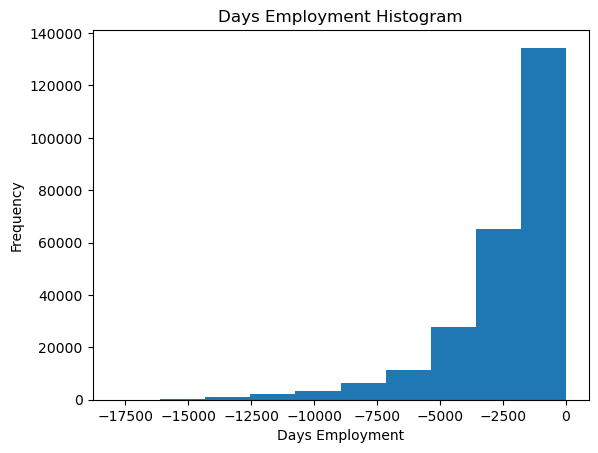

In [9]:
# Create an anomalous flag column
data['DAYS_EMPLOYED_ANOM'] = data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

## Corrélations

 Pearson correlation coefficient interpretation :

    .00-.19 “very weak”
    .20-.39 “weak”
    .40-.59 “moderate”
    .60-.79 “strong”
    .80-1.0 “very strong”


# Find correlations with the target and sort
correlations = data.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

### Effet de l'âge

In [10]:
# Find the correlation of the positive days since birth and target
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_BIRTH'].corr(data['TARGET'])

-0.07823930830982709

# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(data['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(data.loc[data['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend()

In [11]:
# Age information into a separate dataframe
age_data = data[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

On remarque que plus les clients sont jeunes plus ils ont tendance à ne pas remboourser leur emprunt (10 % de faillite bancaire chez les plus jeune VS moins de 4% pour les plus âgés avec une diminution croissante.

### Exterior Sources (EXT_SOURCE)

# Extract the EXT_SOURCE variables and show correlations
ext_data = data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

On remarque que les 3 sources extérieures de notation ont une corrélation négative avec la target, c'est à dire que plus la notation est bonne par la source, plus le remboursement est fiable. La corrélation avec days birth montre que cette variable entre en compte dans le calcul.

plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data.loc[data['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data.loc[data['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)
    

La variable EXT_SOURCE_3 est celle qui représente le plus une différence entre les target 0 et 1, elle sera donc utile pour un modèle de machine learning.

## Pairs Plot

# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:10000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    #hue = 'TARGET', 
                    #vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
#grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
#grid.map_diag(sns.kdeplot)

# Bottom is density plot
#grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

#plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

# <a name="C3">3. Feature Engineering </a>
<a href="#C0">SOMMAIRE</a>

## Polynomial Features

In [12]:
# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [13]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [14]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [15]:
#regardons si les nouvelles features crées sont corrélées avec la target
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


On créer un nouveau dataframe avec les poly features dedans afin de pouvoir tester plus tard lequel est le mieux pour du ML.

In [16]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
data_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Print out the new shapes
print('Data with polynomial features shape: ', data_poly.shape)
print('Data without polynomial features shape: ', data.shape)

Data with polynomial features shape:  (307511, 279)
Data without polynomial features shape:  (307511, 243)


## Domain Knowledge Features

five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [17]:
data_domain = data.copy()

data_domain['CREDIT_INCOME_PERCENT'] = data_domain['AMT_CREDIT'] / data_domain['AMT_INCOME_TOTAL']
data_domain['ANNUITY_INCOME_PERCENT'] = data_domain['AMT_ANNUITY'] / data_domain['AMT_INCOME_TOTAL']
data_domain['CREDIT_TERM'] = data_domain['AMT_ANNUITY'] / data_domain['AMT_CREDIT']
data_domain['DAYS_EMPLOYED_PERCENT'] = data_domain['DAYS_EMPLOYED'] / data_domain['DAYS_BIRTH']

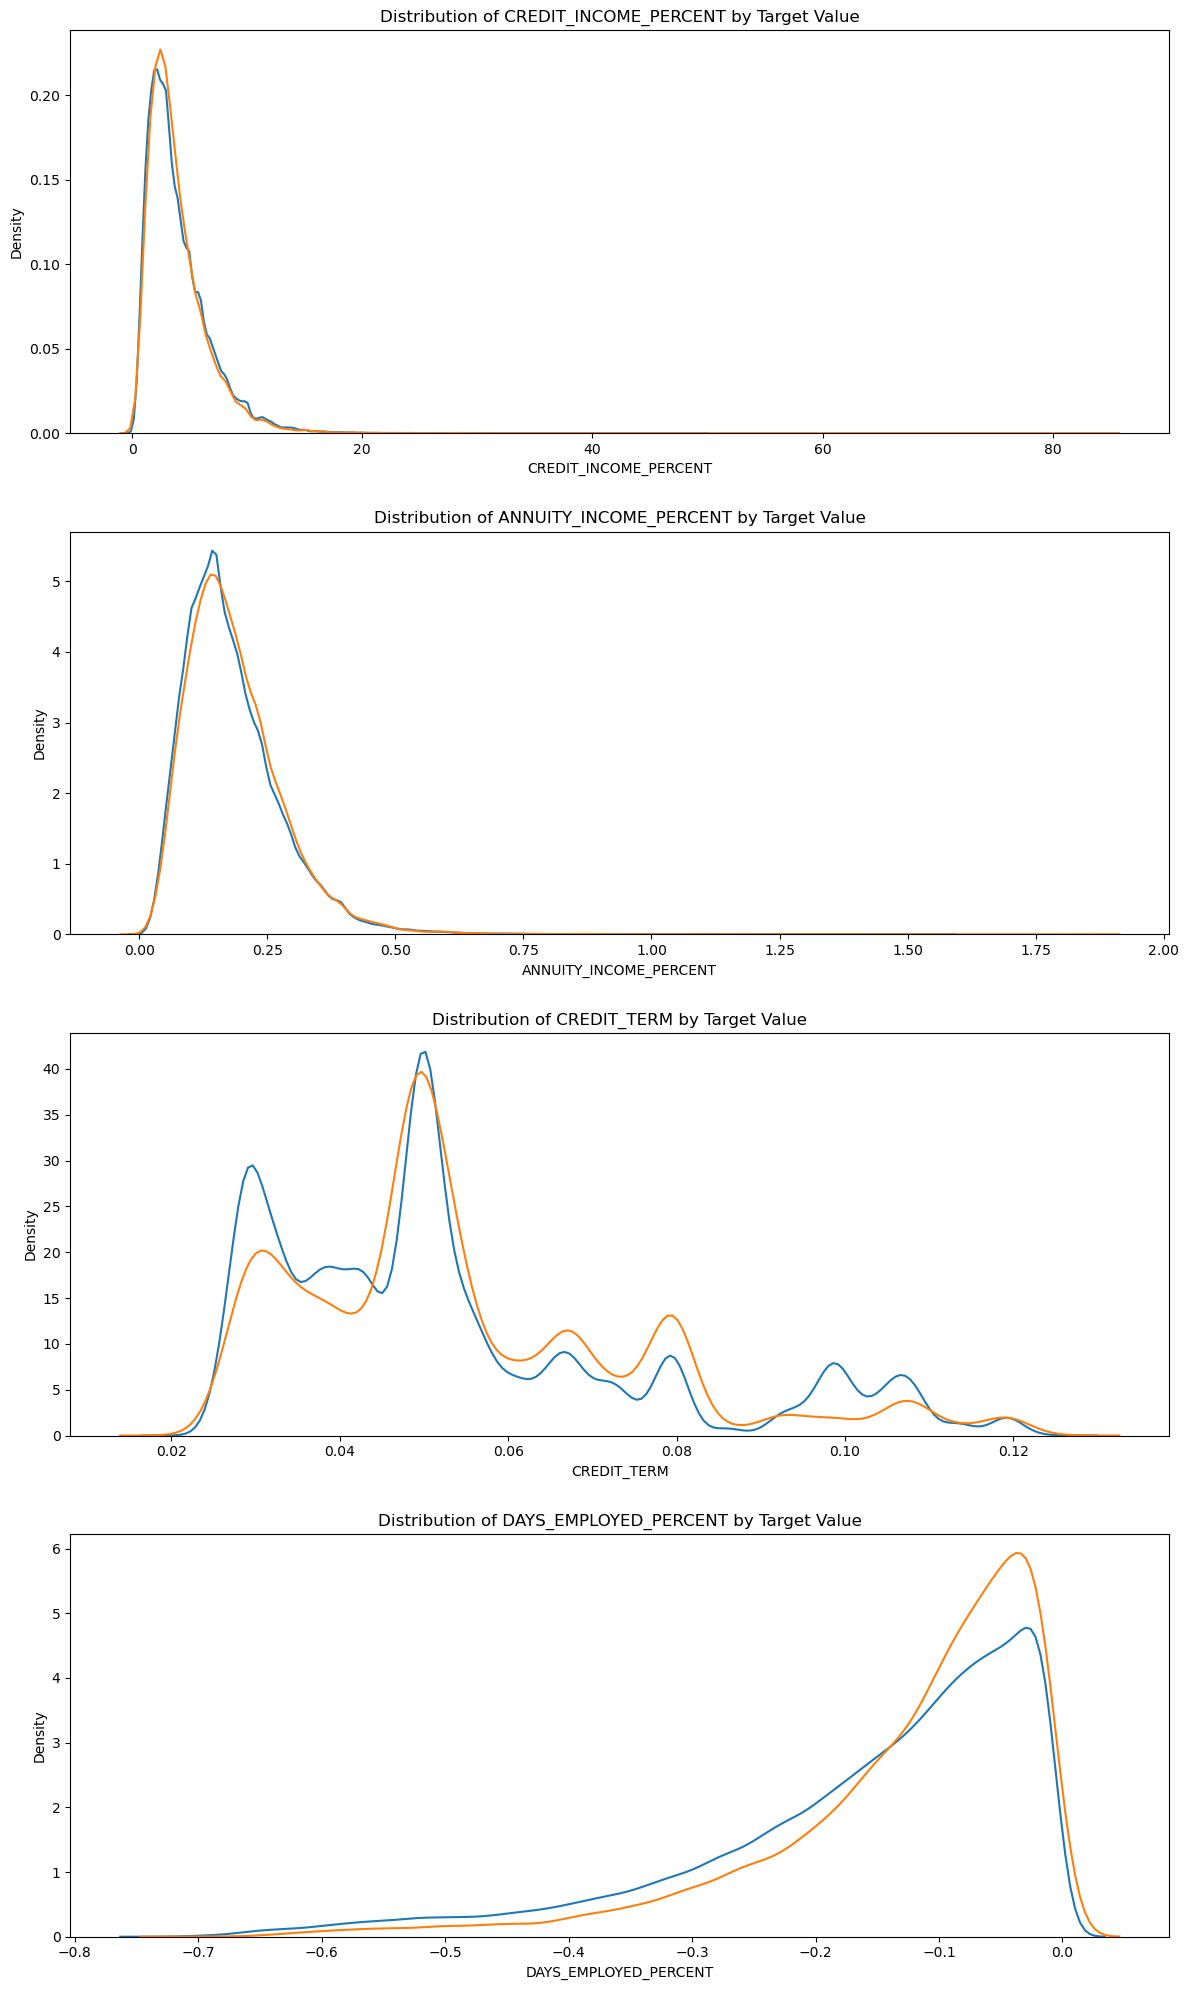

In [18]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data_domain.loc[data_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data_domain.loc[data_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# - - - - - - - PARTIE 2 : MODELISATION  - - - - - - - -

# <a name="C4">4. Fonctions, tests différents modèles sur data  </a>
<a href="#C0">SOMMAIRE</a>

- Entraîner plusieurs modèles de classification : approche naïve (DummyClassifier), régression logistique, arbre de décision, random forests, lightgbm/catboost
- Cross-validation avec GridSearchCV (pour la recherche des hyper-paramètres, scoring=roc auc). Si jamais la recherche est trop longue, prendre un sous-échantillon du dataset de train (après le prétraitement).
- Metrics : recall, F1-score, AUC, matrice de confusion
- Metric pour recherche hyperparam AUC ROC
- Bonus : Créer une fonction regroupant la recherche des hyperparamètres et le calcul de performance.
- Récapitulatif des performances (faire un tableau récapitulatif des performances)


### Séparation Train Test & Prétraitements additionnels

In [19]:
from sklearn.model_selection import train_test_split

# Diviser les caractéristiques (X) et la variable cible (y)
X = data.drop(['TARGET','SK_ID_CURR'], axis=1)
y = data['TARGET']

# Effectuer la division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles de données
print("Taille de l'ensemble d'entraînement :", len(X_train))
print("Taille de l'ensemble de test :", len(X_test))

Taille de l'ensemble d'entraînement : 246008
Taille de l'ensemble de test : 61503


In [20]:
from sklearn.preprocessing import MinMaxScaler

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (246008, 241)
Testing data shape:  (61503, 241)


In [21]:
#initialisation du stockage des résultats
resultats = pd.DataFrame(columns=['Données','Modèle','recall','F1-score' ,'AUC ROC'])

## Création d'une fonction pour rechercher les hyperparamètres et afficher les résultats

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, confusion_matrix, auc, roc_curve

def evaluate_model(model, params, X_train, y_train, X_test, y_test):
    # scorer AUC ROC
    scorer = make_scorer(roc_auc_score)

    # recherche hyperparams avec GridSearchCV et Cross Validation
    grid_search = GridSearchCV(model, params, scoring=scorer, cv=5)
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres et le meilleur modèle
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Évaluer les performances sur l'ensemble de test
    y_pred = best_model.predict(X_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_model = roc_auc_score(y_test, y_scores)
    cm = confusion_matrix(y_test, y_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres :", best_params)
    print("Recall :", recall)
    print("F1-score :", f1)
    print("AUC ROC :", auc_model)
    print("Matrice de confusion :\n", cm)

    # Calculer la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Afficher la courbe ROC
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')  # Droite AUC-ROC (aléatoire)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC ')
    plt.legend(loc="lower right")
    plt.show()
    
    #stocker les resultats
    results = [str(best_model),str(round(recall,5)),str(round(f1,5)),str(round(auc_model,5))]

    # Retourner le meilleur modèle
    return best_model, results, cm, best_params 




def trackwithml(results,params,donnees,balanced) :
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.autolog(disable=True) 
    mlflow.set_experiment("Scoring modèles tracker")
    #balanced = yes or no
    name = results[0]
    recall = results[1]
    f1 = results[2]
    auc_model = results[3]
    feature_engineering_type = donnees
    with mlflow.start_run(run_name=name):
        mlflow.log_params(params)
        mlflow.log_metric("roc_auc", auc_model)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_param("Feature Engineering", feature_engineering_type)
        mlflow.log_param("Balanced", balanced)
    mlflow.end_run()
    print('Model '+name+' with '+feature_engineering_type+' /balanced : '+balanced+' == DONE')

In [23]:
données = 'data de base'

## Dummy Classifier

In [24]:
mlflow.set_experiment("Scoring modèles tracker")

Traceback (most recent call last):
  File "C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 299, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 392, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1239, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\mlflow\store\tracking\file_store.py", line 1232, in _read_helper
    result = read_yaml(root, file_name)
  File "C:\Users\Me\AppData\Roaming\Python\Python39\site-packages\mlflow\utils\file_utils.py", line 227, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
m

<Experiment: artifact_location='file:///C:/Users/Me/Documents/1-%20DATA%20SCIENCE/Projet%207/mlruns/259649161223741812', creation_time=1686747607648, experiment_id='259649161223741812', last_update_time=1686747607648, lifecycle_stage='active', name='Scoring modèles tracker', tags={}>

Meilleurs hyperparamètres : {'strategy': 'most_frequent'}
Recall : 0.0
F1-score : 0.0
AUC ROC : 0.5
Matrice de confusion :
 [[56554     0]
 [ 4949     0]]


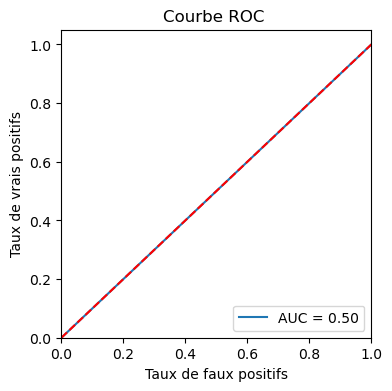

In [25]:
#import
from sklearn.dummy import DummyClassifier

# define model
model = DummyClassifier()

#define params
params = {'strategy': ['most_frequent','prior']}

dummy_best,dummy_results,dummy_cm, dummy_params = evaluate_model(model,params,X_train,y_train,X_test,y_test)

In [26]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), dummy_results[0][:200],dummy_results[1],dummy_results[2],dummy_results[3]]
#affichage des résultats
resultats

,Données,Modèle,recall,F1-score,AUC ROC
0,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5


## Logistic Regression Implementation

In [27]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", X_train_small.shape)

Nouvelle taille de l'échantillon d'entraînement : (73802, 241)


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'lbfgs'}
Recall : 0.6639725197009497
F1-score : 0.25408853663251496
AUC ROC : 0.7424573204238847
Matrice de confusion :
 [[38924 17630]
 [ 1663  3286]]


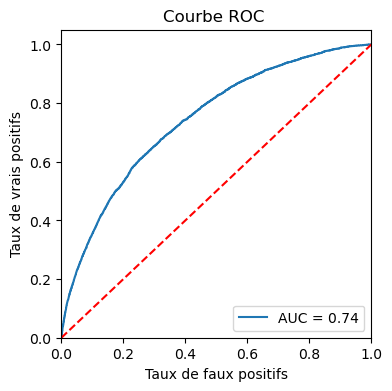

In [28]:
#import
from sklearn.linear_model import LogisticRegression

# define model
model2 = LogisticRegression(class_weight='balanced')

#define params
params2 = {'C': [0.01,0.001,0.0001],
         'solver': ['saga', 'lbfgs']}

logreg_best,logreg_results,logreg_cm, logreg_params = evaluate_model(model2,params2,X_train_small,y_train_small,X_test,y_test)

In [29]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), logreg_results[0][:200],logreg_results[1],logreg_results[2],logreg_results[3]]
#affichage des résultats
resultats

,Données,Modèle,recall,F1-score,AUC ROC
0,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5
1,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246


In [30]:
trackwithml(logreg_results,logreg_params,données,'yes')

Model LogisticRegression(C=0.01, class_weight='balanced') with data de base /balanced : yes == DONE


## Decision tree

Meilleurs hyperparamètres : {'criterion': 'gini', 'max_depth': 6, 'max_features': 211}
Recall : 0.6651848858355224
F1-score : 0.2373553480659
AUC ROC : 0.7083311345194406
Matrice de confusion :
 [[37056 19498]
 [ 1657  3292]]


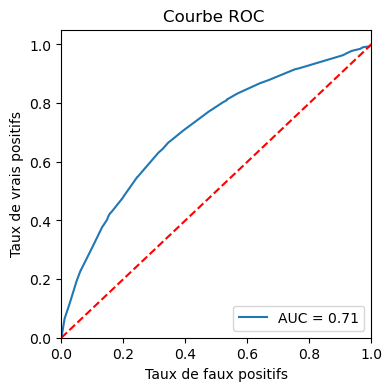

In [131]:
#import
from sklearn import tree

# define model
modeldt = tree.DecisionTreeClassifier(random_state=48,class_weight='balanced')

#define params
paramsdt = {'criterion': ['gini', 'entropy'],
             'max_depth': [2, 4, 6, 8, 10, 12],
             'max_features': list(range(1, X.shape[1] + 1, 30))}

DT_best,DT_results,DT_cm, DT_params = evaluate_model(modeldt,paramsdt,X_train_small,y_train_small,X_test,y_test)

In [32]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), DT_results[0][:200],DT_results[1],DT_results[2],DT_results[3]]
#affichage des résultats
resultats

,Données,Modèle,recall,F1-score,AUC ROC
0,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5
1,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246
2,data de base,DecisionTreeClassifier(class_weight='balanced'...,0.62114,0.2148,0.65153


In [132]:
trackwithml(DT_results,DT_params,données,'yes')

Model DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_features=211,
                       random_state=48) with data de base /balanced : yes == DONE


## Random Forrest

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent worker

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Paral

Meilleurs hyperparamètres : {'max_depth': 5, 'max_features': 'auto'}
Recall : 0.6427561123459284
F1-score : 0.24427891260943022
AUC ROC : 0.7212827622882946
Matrice de confusion :
 [[38640 17914]
 [ 1768  3181]]


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


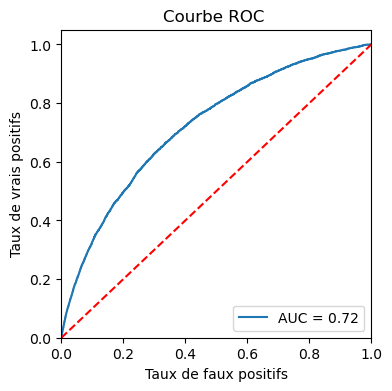

In [34]:
#import
from sklearn.ensemble import RandomForestClassifier

# define model
model3 = RandomForestClassifier(random_state=48,n_jobs=-1,verbose=1,class_weight='balanced')

#define params
params3 = {'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [5,8,10,12,15]}

RF_best,RF_results,RF_cm, RF_params = evaluate_model(model3,params3,X_train_small,y_train_small,X_test,y_test)

In [35]:
RF_best.fit(X_train_small,y_train_small)

# Extract feature importances
feature_importance_values = RF_best.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


In [36]:
trackwithml(RF_results,RF_params,données,'yes')

Model RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_features='auto', n_jobs=-1, random_state=48,
                       verbose=1) with data de base /balanced : yes == DONE


In [37]:
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances

,feature,importance
32,EXT_SOURCE_3,0.179402
31,EXT_SOURCE_2,0.163187
30,EXT_SOURCE_1,0.067848
10,DAYS_EMPLOYED,0.058104
81,DAYS_LAST_PHONE_CHANGE,0.044105
...,...,...
176,ORGANIZATION_TYPE_Culture,0.000000
160,OCCUPATION_TYPE_Waiters/barmen staff,0.000000
150,OCCUPATION_TYPE_IT staff,0.000000
148,OCCUPATION_TYPE_HR staff,0.000000


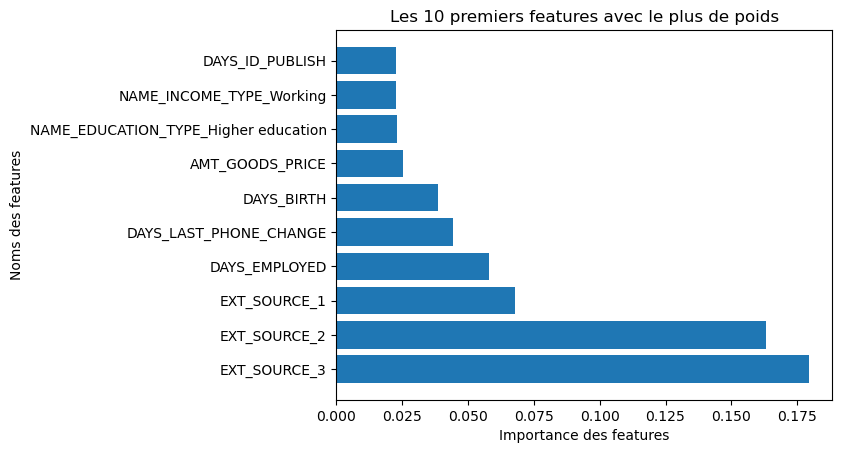

In [38]:
plt.barh(feature_importances.feature[:10], feature_importances.importance[:10])
plt.title("Les 10 premiers features avec le plus de poids")
plt.xlabel("Importance des features")
plt.ylabel("Noms des features")
plt.show()

In [39]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), RF_results[0][:200],RF_results[1],RF_results[2],RF_results[3]]
#affichage des résultats
resultats

,Données,Modèle,recall,F1-score,AUC ROC
0,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5
1,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246
2,data de base,DecisionTreeClassifier(class_weight='balanced'...,0.62114,0.2148,0.65153
3,data de base,RandomForestClassifier(class_weight='balanced'...,0.64276,0.24428,0.72128


## LightGboost

In [40]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
X_train_xsmall, _, y_train_xsmall, _ = train_test_split(X_train, y_train, test_size=0.92, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", X_train_xsmall.shape)

Nouvelle taille de l'échantillon d'entraînement : (19680, 241)


Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 2, 'reg_alpha': 0.31622776601683794, 'reg_lambda': 100.0}
Recall : 0.6643766417458072
F1-score : 0.2544596215609643
AUC ROC : 0.7377882366328151
Matrice de confusion :
 [[38948 17606]
 [ 1661  3288]]


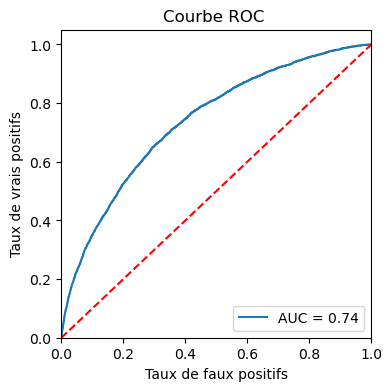

In [41]:
#import
import lightgbm as lgb

# define model
model4 = lgb.LGBMClassifier(class_weight='balanced')

#define params
params4 = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2,3,4, 5],
    'reg_alpha': np.logspace(-3, 2, 3),
    'reg_lambda': np.logspace(-3, 2, 3)}


LGB_best , LGB_results , LGB_cm, LGB_params = evaluate_model(model4,params4,X_train_xsmall,y_train_xsmall,X_test,y_test)

In [42]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), LGB_results[0][:200],LGB_results[1],LGB_results[2],LGB_results[3]]
#affichage des résultats
resultats

,Données,Modèle,recall,F1-score,AUC ROC
0,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5
1,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246
2,data de base,DecisionTreeClassifier(class_weight='balanced'...,0.62114,0.2148,0.65153
3,data de base,RandomForestClassifier(class_weight='balanced'...,0.64276,0.24428,0.72128
4,data de base,"LGBMClassifier(class_weight='balanced', max_de...",0.66438,0.25446,0.73779


In [43]:
trackwithml(LGB_results,LGB_params,données,'yes')

Model LGBMClassifier(class_weight='balanced', max_depth=2,
               reg_alpha=0.31622776601683794, reg_lambda=100.0) with data de base /balanced : yes == DONE


## CatBoost

#import
from catboost import CatBoostClassifier

define model
model5 = CatBoostClassifier(class_weight='balanced')

#define params
params5 = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5],
}

CB_best , CB_results , CB_cm, CB_params = evaluate_model(model5,params5,X_train_xsmall,y_train_xsmall,X_test,y_test)

#stock resultts
recall = CB_results[1]
f1 = CB_results[2]
auc_model = CB_results[3]
cm_text = np.array2string(CB_cm, separator=", ")
with open("confusion_matrix_CB.txt", "w") as file:
    file.write(cm_text)

#enregistrement du test
mlflow.log_params(CB_params)
mlflow.log_metric("roc_auc", auc_model)
mlflow.log_metric("recall", recall)
mlflow.log_metric("f1_score", f1)
mlflow.log_artifact("confusion_matrix_CB.txt")  # Enregistrement de la matrice de confusion

#enregistrement du modèle
#mlflow.sklearn.log_model(best_model, "best_model")

#Définition du nom de l'expérience avec le type de feature engineering
feature_engineering_type = données
#Enregistrement du texte "data de base" en tant que paramètre
mlflow.log_param("Feature Engineering", feature_engineering_type)

#on stocke les résultats du model
resultats.loc[len(resultats)] = [str(données), CB_results[0][:200],CB_results[1],CB_results[2],CB_results[3]]
#affichage des résultats
resultats

# Test avec autre features
## poly_features

In [44]:
poly_features

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET,SK_ID_CURR
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,...,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,1,100002
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,0,100003
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,0,100004
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,0,100006
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,1.0,0.145570,0.681632,0.535276,9327.0,0.021191,0.099226,0.077920,1357.735625,0.464623,...,4333.535804,0.195302,3403.064320,5.929720e+07,0.153368,2672.378236,4.656525e+07,8.113830e+11,0,456251
307507,1.0,0.505998,0.115992,0.535276,20775.0,0.256034,0.058692,0.270849,10512.107006,0.013454,...,279.510194,0.033234,1289.874083,5.006225e+07,0.153368,5952.466801,2.310256e+08,8.966503e+12,0,456252
307508,1.0,0.744026,0.535722,0.218859,14966.0,0.553575,0.398591,0.162837,11135.099105,0.286998,...,4295.209004,0.025661,1754.727146,1.199916e+08,0.010483,716.860892,4.902031e+07,3.352102e+12,0,456253
307509,1.0,0.505998,0.514163,0.661024,11961.0,0.256034,0.260165,0.334477,6052.241247,0.264363,...,3162.050698,0.224665,4065.229651,7.355897e+07,0.288836,5226.384299,9.456968e+07,1.711207e+12,1,456254


In [45]:
# Diviser les caractéristiques (X) et la variable cible (y)
Xpoly = poly_features.drop(['TARGET','SK_ID_CURR','1'], axis=1)
ypoly = poly_features['TARGET']

# Effectuer la division train/test
Xpoly_train, Xpoly_test, ypoly_train, ypoly_test = train_test_split(Xpoly, ypoly, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles de données
print("Taille de l'ensemble d'entraînement :", len(Xpoly_train))
print("Taille de l'ensemble de test :", len(Xpoly_test))

Taille de l'ensemble d'entraînement : 246008
Taille de l'ensemble de test : 61503


In [46]:
# Feature names
features = list(Xpoly_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(Xpoly_train)

# Transform both training and testing data
Xpoly_train = imputer.transform(Xpoly_train)
Xpoly_test = imputer.transform(Xpoly_test)

# Repeat with the scaler
scaler.fit(Xpoly_train)
Xpoly_train = scaler.transform(Xpoly_train)
Xpoly_test = scaler.transform(Xpoly_test)

print('Training data shape: ', Xpoly_train.shape)
print('Testing data shape: ', Xpoly_test.shape)

Training data shape:  (246008, 34)
Testing data shape:  (61503, 34)


In [47]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
Xpoly_train_xsmall, _, ypoly_train_xsmall, _ = train_test_split(Xpoly_train, ypoly_train, test_size=0.92, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", Xpoly_train_xsmall.shape)

Nouvelle taille de l'échantillon d'entraînement : (19680, 34)


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'saga'}
Recall : 0.6831683168316832
F1-score : 0.2351509250243428
AUC ROC : 0.7201829349323134
Matrice de confusion :
 [[36128 20426]
 [ 1568  3381]]


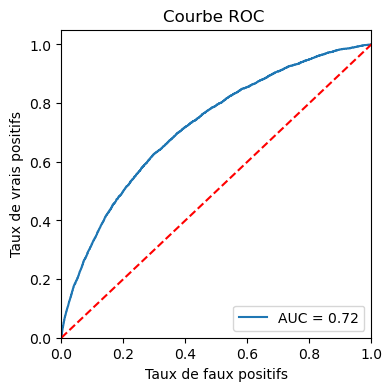

In [48]:
logregpoly_best,logregpoly_results,logregpoly_cm, logregpoly_params = evaluate_model(model2,params2,Xpoly_train_xsmall,ypoly_train_xsmall,Xpoly_test,ypoly_test)

In [49]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str('poly_features'), logregpoly_results[0][:200],logregpoly_results[1],logregpoly_results[2],logregpoly_results[3]]
#affichage des résultats
resultats

,Données,Modèle,recall,F1-score,AUC ROC
0,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5
1,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246
2,data de base,DecisionTreeClassifier(class_weight='balanced'...,0.62114,0.2148,0.65153
3,data de base,RandomForestClassifier(class_weight='balanced'...,0.64276,0.24428,0.72128
4,data de base,"LGBMClassifier(class_weight='balanced', max_de...",0.66438,0.25446,0.73779
5,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23515,0.72018


In [50]:
trackwithml(logregpoly_results,logregpoly_params,'poly features only','yes')

Model LogisticRegression(C=0.01, class_weight='balanced', solver='saga') with poly features only /balanced : yes == DONE


## data_domain

In [51]:
data_domain

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,1,0,False,2.007889,0.121978,0.060749,-0.067329
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0,False,4.790750,0.132217,0.027598,-0.070862
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,False,2.000000,0.100000,0.050000,-0.011814
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,False,2.316167,0.219900,0.094941,-0.159905
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,False,4.222222,0.179963,0.042623,-0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,1,0,False,1.617143,0.174971,0.108198,-0.025303
307507,456252,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,1,0,True,3.743750,0.166687,0.044524,NaN
307508,456253,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,0,0,1,0,0,False,4.429176,0.195941,0.044239,-0.529266
307509,456254,1,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,1,0,False,2.164368,0.118158,0.054592,-0.400134


In [52]:
# Diviser les caractéristiques (X) et la variable cible (y)
Xdomain = data_domain.drop(['TARGET','SK_ID_CURR'], axis=1)
ydomain = data_domain['TARGET']

# Effectuer la division train/test
Xdomain_train, Xdomain_test, ydomain_train, ydomain_test = train_test_split(Xdomain, ydomain, test_size=0.2, random_state=42)

# Vérifier les tailles des ensembles de données
print("Taille de l'ensemble d'entraînement :", len(Xdomain_train))
print("Taille de l'ensemble de test :", len(Xdomain_test))

Taille de l'ensemble d'entraînement : 246008
Taille de l'ensemble de test : 61503


In [53]:
# Feature names
features = list(Xdomain_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(Xdomain_train)

# Transform both training and testing data
Xdomain_train = imputer.transform(Xdomain_train)
Xdomain_test = imputer.transform(Xdomain_test)

# Repeat with the scaler
scaler.fit(Xdomain_train)
Xdomain_train = scaler.transform(Xdomain_train)
Xdomain_test = scaler.transform(Xdomain_test)

print('Training data shape: ', Xdomain_train.shape)
print('Testing data shape: ', Xdomain_test.shape)

Training data shape:  (246008, 245)
Testing data shape:  (61503, 245)


In [54]:
# Diviser l'ensemble de données en un sous-ensemble plus petit pour l'entraînement et le test
Xdomain_train_xsmall, _, ydomain_train_xsmall, _ = train_test_split(Xdomain_train, ydomain_train, test_size=0.92, random_state=42)

# Afficher la taille du nouvel échantillon d'entraînement
print("Nouvelle taille de l'échantillon d'entraînement :", Xdomain_train_xsmall.shape)

Nouvelle taille de l'échantillon d'entraînement : (19680, 245)


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'saga'}
Recall : 0.6674075570822389
F1-score : 0.2526291636391449
AUC ROC : 0.7368927212177501
Matrice de confusion :
 [[38657 17897]
 [ 1646  3303]]


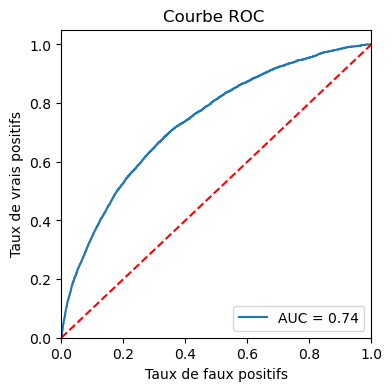

In [55]:
logregdomain_best,logregdomain_results,logregdomain_cm, logregdomain_params = evaluate_model(model2,params2,Xdomain_train_xsmall,ydomain_train_xsmall,Xdomain_test,ydomain_test)

In [56]:
#on stocke les résultats du model
resultats.loc[len(resultats)] = [str('data_domain'), logregdomain_results[0][:200],logregdomain_results[1],logregdomain_results[2],logregdomain_results[3]]
#affichage des résultats
resultats

,Données,Modèle,recall,F1-score,AUC ROC
0,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5
1,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246
2,data de base,DecisionTreeClassifier(class_weight='balanced'...,0.62114,0.2148,0.65153
3,data de base,RandomForestClassifier(class_weight='balanced'...,0.64276,0.24428,0.72128
4,data de base,"LGBMClassifier(class_weight='balanced', max_de...",0.66438,0.25446,0.73779
5,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23515,0.72018
6,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66741,0.25263,0.73689


In [57]:
trackwithml(logregdomain_results,logregdomain_params,'data de base et domain','yes')

Model LogisticRegression(C=0.01, class_weight='balanced', solver='saga') with data de base et domain /balanced : yes == DONE


# Features selection


In [93]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 5  # Minimum number of features to consider
clf = LogisticRegression(C=0.01, class_weight='balanced', solver='saga')
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(Xdomain_train_xsmall, ydomain_train_xsmall)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 21


In [96]:
selected_features = [feature for feature, selected in zip(X.columns, rfecv.support_) if selected]
print(f"Selected feature: {selected_features}")


Selected feature: ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'CODE_GENDER_M', 'NAME_EDUCATION_TYPE_Higher education', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_Trade: type 3', 'FONDKAPREMONT_MODE_reg oper spec account']


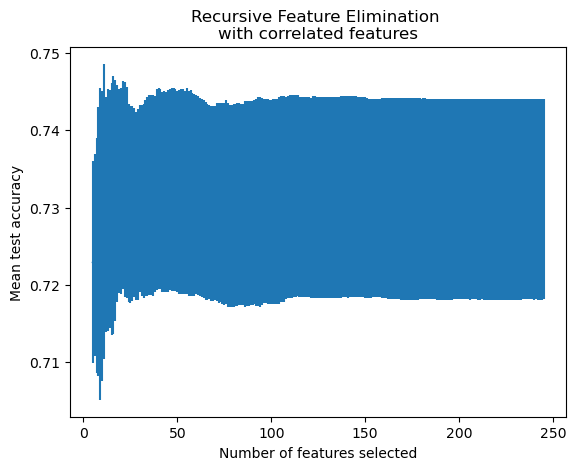

In [95]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [89]:
logregdomain_best

LogisticRegression(C=0.01, class_weight='balanced', solver='saga')

# make scorer
Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
Vous pourrez supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP

In [137]:
def cost_function(y_true, y_pred):
    tp = np.sum((y_true == 0) & (y_pred == 0))
    tn = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    total_cost = tn * 1 - fp * 1 - fn * 10
    return total_cost


from sklearn.metrics import make_scorer

cost_scorer = make_scorer(cost_function, greater_is_better=True)

In [138]:
def evaluate_model_cost_function(model, params, X_train, y_train, X_test, y_test,cost_scorer):
    # recherche hyperparams avec GridSearchCV et Cross Validation
    grid_search = GridSearchCV(model, params, scoring=cost_scorer, cv=5)
    grid_search.fit(X_train, y_train)

    # Obtenir les meilleurs hyperparamètres et le meilleur modèle
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Évaluer les performances sur l'ensemble de test
    y_pred = best_model.predict(X_test)
    y_scores = best_model.predict_proba(X_test)[:, 1]
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_model = roc_auc_score(y_test, y_scores)
    cm = confusion_matrix(y_test, y_pred)
    cost_score = cost_function(y_test, y_pred)

    # Afficher les résultats
    print("Meilleurs hyperparamètres :", best_params)
    print("Recall :", recall)
    print("F1-score :", f1)
    print("AUC ROC :", auc_model)
    print("Cost Function :", cost_score)
    print("Matrice de confusion :\n", cm)

    # Calculer la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores)

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Afficher la courbe ROC
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')  # Droite AUC-ROC (aléatoire)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC ')
    plt.legend(loc="lower right")
    plt.show()
    
    #stocker les resultats
    results = [str(best_model),str(round(recall,5)),str(round(f1,5)),str(round(auc_model,5)),str(round(cost_score,5))]

    # Retourner le meilleur modèle
    return best_model, results, cm, best_params 

### test du nouveau modèle de scoring LogReg et LGMboost

In [139]:
#initialisation du stockage des résultats
resultats_cost = pd.DataFrame(columns=['Données','Modèle','recall','F1-score' ,'AUC ROC','cost_function'])

Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'saga'}
Recall : 0.6831683168316832
F1-score : 0.23514274785269673
AUC ROC : 0.7201825276232539
Cost Function : -32726
Matrice de confusion :
 [[36127 20427]
 [ 1568  3381]]


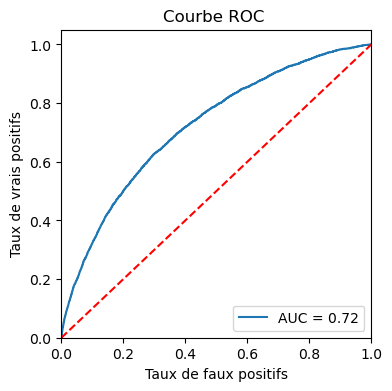

In [140]:
#LOG REG sur polyfeatures
lrpl_best, lrpl_results, lrpl_cm, lrpl_params = evaluate_model_cost_function(model2, params2, Xpoly_train_xsmall, ypoly_train_xsmall, Xpoly_test, ypoly_test,cost_scorer)

In [141]:
#on stocke les résultats du model
resultats_cost.loc[len(resultats_cost)] = [str('poly_features'), lrpl_results[0][:200],lrpl_results[1],lrpl_results[2],lrpl_results[3],lrpl_results[4]]
#affichage des résultats
resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726


In [166]:
#fonction save experience in ML avec cost function
def trackwithmlcostfunction(results,params,donnees,balanced) :
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    mlflow.autolog(disable=True) 
    mlflow.set_experiment("Scoring modèles tracker avec cost function ")
    #balanced = yes or no
    name = results[0]
    recall = results[1]
    f1 = results[2]
    auc_model = results[3]
    cost_score=results[4]
    feature_engineering_type = donnees
    with mlflow.start_run(run_name=name):
        mlflow.log_params(params)
        mlflow.log_metric("roc_auc", auc_model)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_param("Feature Engineering", feature_engineering_type)
        mlflow.log_param("Balanced", balanced)
        mlflow.log_metric("Cost Score", cost_score)
    mlflow.end_run()
    print('Model '+name+' with '+feature_engineering_type+' /balanced : '+balanced+' == DONE')

In [168]:
trackwithmlcostfunction(lrpl_results,lrpl_params,'poly_features','yes')

Model LogisticRegression(C=0.01, class_weight='balanced', solver='saga') with poly_features /balanced : yes == DONE


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'saga'}
Recall : 0.6676096181046676
F1-score : 0.2526766595289079
AUC ROC : 0.7368919994946794
Cost Function : -31045
Matrice de confusion :
 [[38655 17899]
 [ 1645  3304]]


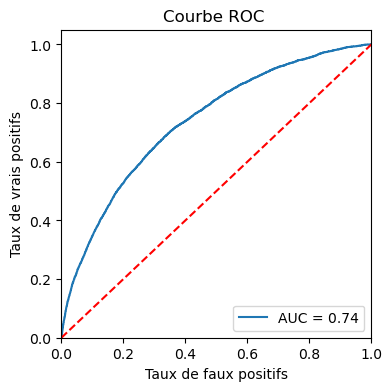

In [146]:
#LOGREG sur data_domain
lrdom_best, lrdom_results, lrdom_cm, lrdom_params = evaluate_model_cost_function(model2, params2, Xdomain_train_xsmall, ydomain_train_xsmall, Xdomain_test, ydomain_test,cost_scorer)


In [147]:
#on stocke les résultats du model
resultats_cost.loc[len(resultats_cost)] = [str('data_domain'), lrdom_results[0][:200],lrdom_results[1],lrdom_results[2],lrdom_results[3],lrdom_results[4]]
#affichage des résultats
resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726
1,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66761,0.25268,0.73689,-31045


In [169]:
trackwithml(lrdom_results,lrdom_params,'data_domain','yes')

Model LogisticRegression(C=0.01, class_weight='balanced', solver='saga') with data_domain /balanced : yes == DONE


Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 100.0, 'reg_lambda': 0.31622776601683794}
Recall : 0.660133360274803
F1-score : 0.24508627156789198
AUC ROC : 0.7253260425059302
Cost Function : -31997
Matrice de confusion :
 [[38110 18444]
 [ 1682  3267]]


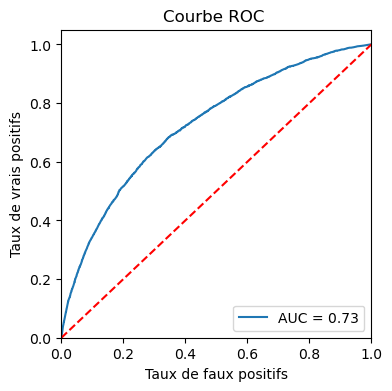

In [148]:
#LGBoost sur polyfeatures
lgpl_best, lgpl_results, lgpl_cm, lgpl_params = evaluate_model_cost_function(model4, params4, Xpoly_train_xsmall, ypoly_train_xsmall, Xpoly_test, ypoly_test,cost_scorer)

In [149]:
#on stocke les résultats du model
resultats_cost.loc[len(resultats_cost)] = [str('poly_features'), lgpl_results[0][:200],lgpl_results[1],lgpl_results[2],lgpl_results[3],lgpl_results[4]]
#affichage des résultats
resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726
1,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66761,0.25268,0.73689,-31045
2,poly_features,"LGBMClassifier(class_weight='balanced', max_de...",0.66013,0.24509,0.72533,-31997


In [170]:
trackwithmlcostfunction(lgpl_results,lgpl_params,'poly_features','yes')

Model LGBMClassifier(class_weight='balanced', max_depth=4, reg_alpha=100.0,
               reg_lambda=0.31622776601683794) with poly_features /balanced : yes == DONE


Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 0.31622776601683794, 'reg_lambda': 100.0}
Recall : 0.6267932915740554
F1-score : 0.2629259196473979
AUC ROC : 0.7432621666985499
Cost Function : -30913
Matrice de confusion :
 [[41009 15545]
 [ 1847  3102]]


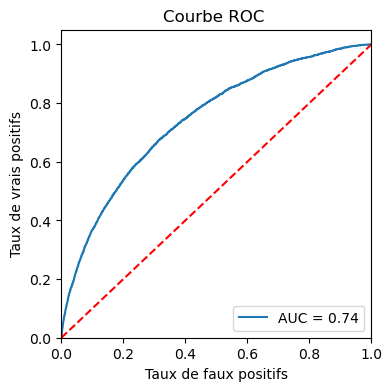

In [150]:
#LGboost sur data_domain
lgdom_best, lgdom_results, lgdom_cm, lgdom_params = evaluate_model_cost_function(model4, params4, Xdomain_train_xsmall, ydomain_train_xsmall, Xdomain_test, ydomain_test,cost_scorer)

In [151]:
#on stocke les résultats du model
resultats_cost.loc[len(resultats_cost)] = [str('data_domain'), lgdom_results[0][:200],lgdom_results[1],lgdom_results[2],lgdom_results[3],lgdom_results[4]]
#affichage des résultats
resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726
1,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66761,0.25268,0.73689,-31045
2,poly_features,"LGBMClassifier(class_weight='balanced', max_de...",0.66013,0.24509,0.72533,-31997
3,data_domain,"LGBMClassifier(class_weight='balanced', max_de...",0.62679,0.26293,0.74326,-30913


In [171]:
trackwithmlcostfunction(lgdom_results,lgdom_params,'data_domain','yes')

Model LGBMClassifier(class_weight='balanced', max_depth=4,
               reg_alpha=0.31622776601683794, reg_lambda=100.0) with data_domain /balanced : yes == DONE


Meilleurs hyperparamètres : {'C': 0.01, 'solver': 'lbfgs'}
Recall : 0.6639725197009497
F1-score : 0.25408853663251496
AUC ROC : 0.7424573204238847
Cost Function : -30974
Matrice de confusion :
 [[38924 17630]
 [ 1663  3286]]


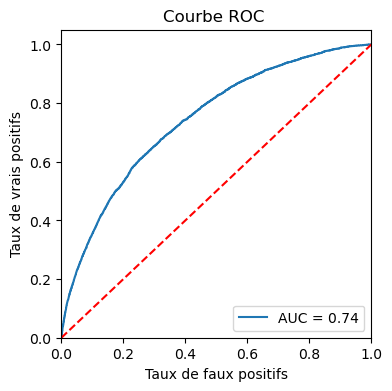

In [152]:
#logreg sur données de base
lrb_best,lrb_results,lrb_cm, lrb_params = evaluate_model_cost_function(model2,params2,X_train_small,y_train_small,X_test,y_test,cost_scorer)

In [153]:
#on stocke les résultats du model
resultats_cost.loc[len(resultats_cost)] = [str('data de base'), lrb_results[0][:200],lrb_results[1],lrb_results[2],lrb_results[3],lrb_results[4]]
#affichage des résultats
resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726
1,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66761,0.25268,0.73689,-31045
2,poly_features,"LGBMClassifier(class_weight='balanced', max_de...",0.66013,0.24509,0.72533,-31997
3,data_domain,"LGBMClassifier(class_weight='balanced', max_de...",0.62679,0.26293,0.74326,-30913
4,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246,-30974


In [172]:
trackwithmlcostfunction(lrb_results,lrb_params,'data de base','yes')

Model LogisticRegression(C=0.01, class_weight='balanced') with data de base /balanced : yes == DONE


Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 4, 'reg_alpha': 100.0, 'reg_lambda': 0.001}
Recall : 0.6728632046878157
F1-score : 0.26176158471878314
AUC ROC : 0.7499657127948203
Cost Function : -30024
Matrice de confusion :
 [[39390 17164]
 [ 1619  3330]]


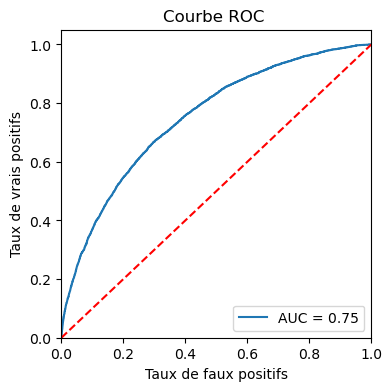

In [154]:
#LGboost sur data de base
lgb_best, lgb_results, lgb_cm, lgb_params = evaluate_model_cost_function(model4, params4, X_train_small,y_train_small,X_test,y_test,cost_scorer)

In [155]:
#on stocke les résultats du model
resultats_cost.loc[len(resultats_cost)] = [str('data de base'), lgb_results[0][:200],lgb_results[1],lgb_results[2],lgb_results[3],lgb_results[4]]
#affichage des résultats
resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726
1,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66761,0.25268,0.73689,-31045
2,poly_features,"LGBMClassifier(class_weight='balanced', max_de...",0.66013,0.24509,0.72533,-31997
3,data_domain,"LGBMClassifier(class_weight='balanced', max_de...",0.62679,0.26293,0.74326,-30913
4,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246,-30974
5,data de base,"LGBMClassifier(class_weight='balanced', max_de...",0.67286,0.26176,0.74997,-30024


In [173]:
trackwithmlcostfunction(lgb_results,lgb_params,'data de base','yes')

Model LGBMClassifier(class_weight='balanced', max_depth=4, reg_alpha=100.0,
               reg_lambda=0.001) with data de base /balanced : yes == DONE


Meilleurs hyperparamètres : {'strategy': 'most_frequent'}
Recall : 0.0
F1-score : 0.0
AUC ROC : 0.5
Cost Function : -49490
Matrice de confusion :
 [[56554     0]
 [ 4949     0]]


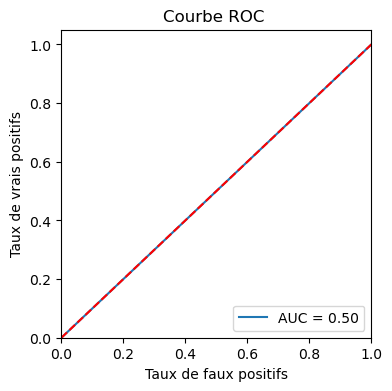

In [156]:
#dummy pour comparaison 
dummy_best,dummy_results,dummy_cm, dummy_params = evaluate_model_cost_function(model,params,X_train,y_train,X_test,y_test,cost_scorer)


In [174]:
trackwithmlcostfunction(dummy_results,dummy_params,'data de base','yes')

Model DummyClassifier(strategy='most_frequent') with data de base /balanced : yes == DONE


In [157]:
#on stocke les résultats du model
resultats_cost.loc[len(resultats_cost)] = [str('data de base'), dummy_results[0][:200],dummy_results[1],dummy_results[2],dummy_results[3],dummy_results[4]]
#affichage des résultats
resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726
1,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66761,0.25268,0.73689,-31045
2,poly_features,"LGBMClassifier(class_weight='balanced', max_de...",0.66013,0.24509,0.72533,-31997
3,data_domain,"LGBMClassifier(class_weight='balanced', max_de...",0.62679,0.26293,0.74326,-30913
4,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246,-30974
5,data de base,"LGBMClassifier(class_weight='balanced', max_de...",0.67286,0.26176,0.74997,-30024
6,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5,-49490


In [163]:
#normalisation du cost score avec le dummy classifier
resultats_cost['normalized_cost'] = resultats_cost['cost_function'].astype(int).apply(lambda x: 1- x / -49490)

resultats_cost

,Données,Modèle,recall,F1-score,AUC ROC,cost_function,normalized_cost
0,poly_features,"LogisticRegression(C=0.01, class_weight='balan...",0.68317,0.23514,0.72018,-32726,0.338735
1,data_domain,"LogisticRegression(C=0.01, class_weight='balan...",0.66761,0.25268,0.73689,-31045,0.372702
2,poly_features,"LGBMClassifier(class_weight='balanced', max_de...",0.66013,0.24509,0.72533,-31997,0.353465
3,data_domain,"LGBMClassifier(class_weight='balanced', max_de...",0.62679,0.26293,0.74326,-30913,0.375369
4,data de base,"LogisticRegression(C=0.01, class_weight='balan...",0.66397,0.25409,0.74246,-30974,0.374136
5,data de base,"LGBMClassifier(class_weight='balanced', max_de...",0.67286,0.26176,0.74997,-30024,0.393332
6,data de base,DummyClassifier(strategy='most_frequent'),0.0,0.0,0.5,-49490,0.000000


# Conclusions pour la suite :
Finalement nous allons sélectionner le modèle Logistic Regression car il s'agit du plus rapide et quasi celui qui obtient les meilleurs résultats.
Nous allons utiliser également les données de data domain pour les mêmes raisons.

Nous allons créer un nouveau notebook pour repartir de zéro et créer une fonction qui permet de transformer les données pour fitter le modèle et aussi lui donner les bonnes entrées pour prédire la faillite bancaire. Dans ce notebook nous étudierons quel est le meilleur seuil pour prédire la faillite bancaire en maximisant le cost_score tel que vu ici.

In [175]:
data_domain.shape

(307511, 247)